# Notebook that attempts to resolve the issues with drop_isolated_sensors() not capturing the clustered sensors.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod
from IC.invisible_cities.reco.deconv_functions import deconvolution_input

import IC.invisible_cities.io.mcinfo_io as mcio

from IC.invisible_cities.cities.components import track_blob_info_creator_extractor
from IC.invisible_cities.io.hits_io        import load_hits
from IC.invisible_cities.io.hits_io        import hits_from_df
from IC.invisible_cities.core              import system_of_units as units
from IC.invisible_cities.types.symbols     import HitEnergy
from IC.invisible_cities.evm.event_model   import HitCollection
from IC.invisible_cities.evm.event_model   import Cluster
from IC.invisible_cities.evm.event_model   import Hit
from IC.invisible_cities.types.ic_types    import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from tqdm import tqdm

In [8]:
# plot hits
def plot_hits(hits):
    pitch = 15.55
    # then applying transformations to convert to 'SiPM outputs'
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
    yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
    zz = hits.Z.unique()

    axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

    fig.suptitle('Hits', fontsize=30)
    #plt.savefig(f'plots/hits_{evt}.pdf')
    plt.show(fig)


### load in some sophronia data

In [12]:
folder_path = 'files/15107_energy_split/'
corr_DES = pd.read_hdf(folder_path + 'corr_DES.h5', 'RECO/Events')

In [13]:
display(corr_DES)
print(f'Events:\n{corr_DES.event.unique()}')

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
28970,1127289,1.742950e+09,0,147.268254,84.815097,1,-343.675,-185.975,0.0,0.0,626.325625,5.457119,3.347841,-1.0,0.000018,-1,-1.0
28971,1127289,1.742950e+09,0,147.268254,84.815097,1,-343.675,184.225,0.0,0.0,626.325625,9.765893,5.991194,-1.0,0.000032,-1,-1.0
28972,1127289,1.742950e+09,0,147.268254,84.815097,1,-265.925,168.675,0.0,0.0,626.325625,5.613680,3.443889,-1.0,0.000018,-1,-1.0
28973,1127289,1.742950e+09,0,147.268254,84.815097,1,-189.175,152.625,0.0,0.0,626.325625,5.255363,3.224068,-1.0,0.000016,-1,-1.0
28974,1127289,1.742950e+09,0,147.268254,84.815097,1,-34.675,-386.625,0.0,0.0,626.325625,5.230516,3.208825,-1.0,0.000017,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30568968,967777,1.742948e+09,0,40.029658,-169.915785,1,-126.975,-309.875,0.0,0.0,609.824750,5.649685,6.021073,-1.0,0.000032,-1,-1.0
30568969,967777,1.742948e+09,0,40.029658,-169.915785,1,-34.675,-263.225,0.0,0.0,609.824750,6.475501,6.901175,-1.0,0.000035,-1,-1.0
30568970,967777,1.742948e+09,0,40.029658,-169.915785,1,42.075,430.525,0.0,0.0,609.824750,6.036242,6.433040,-1.0,0.000037,-1,-1.0
30568971,967777,1.742948e+09,0,40.029658,-169.915785,1,396.725,168.675,0.0,0.0,609.824750,5.916093,6.304994,-1.0,0.000035,-1,-1.0


Events:
[1127289  716942  904297 ... 1195431 1159871  967777]


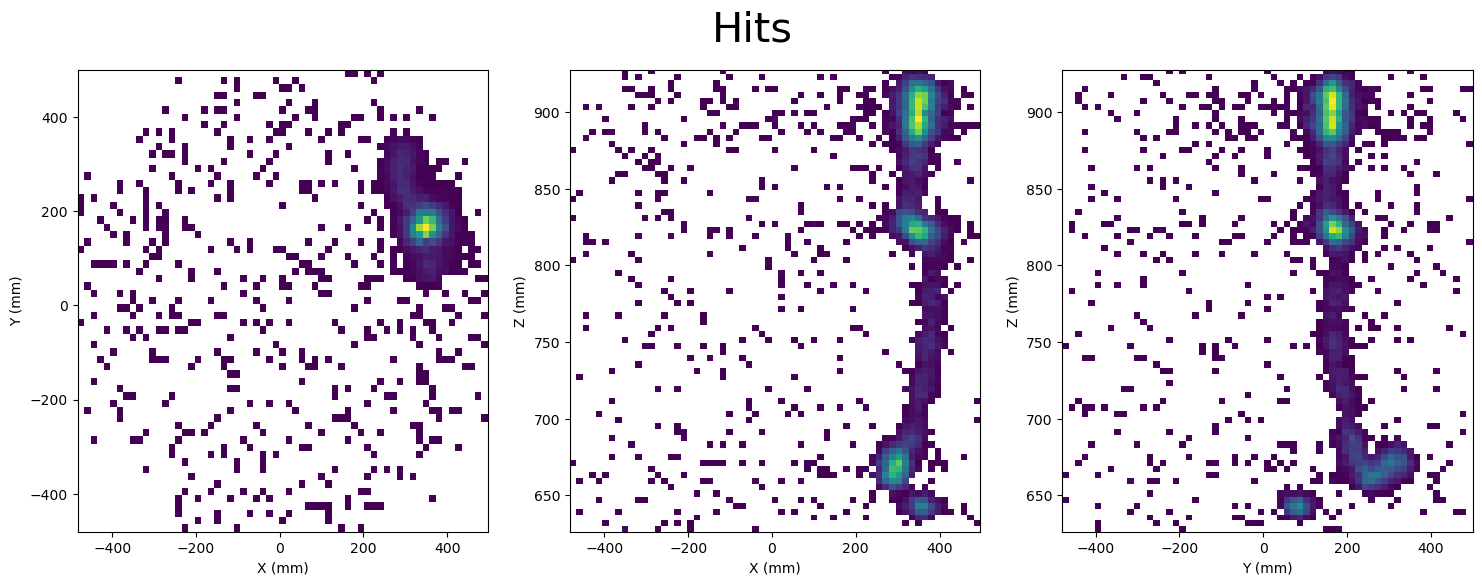

In [15]:
event = corr_DES[corr_DES.event == corr_DES.event.unique()[0]]
plot_hits(event)

In [21]:
q_cut = 6
drop_dist = [16, 16]

cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'])


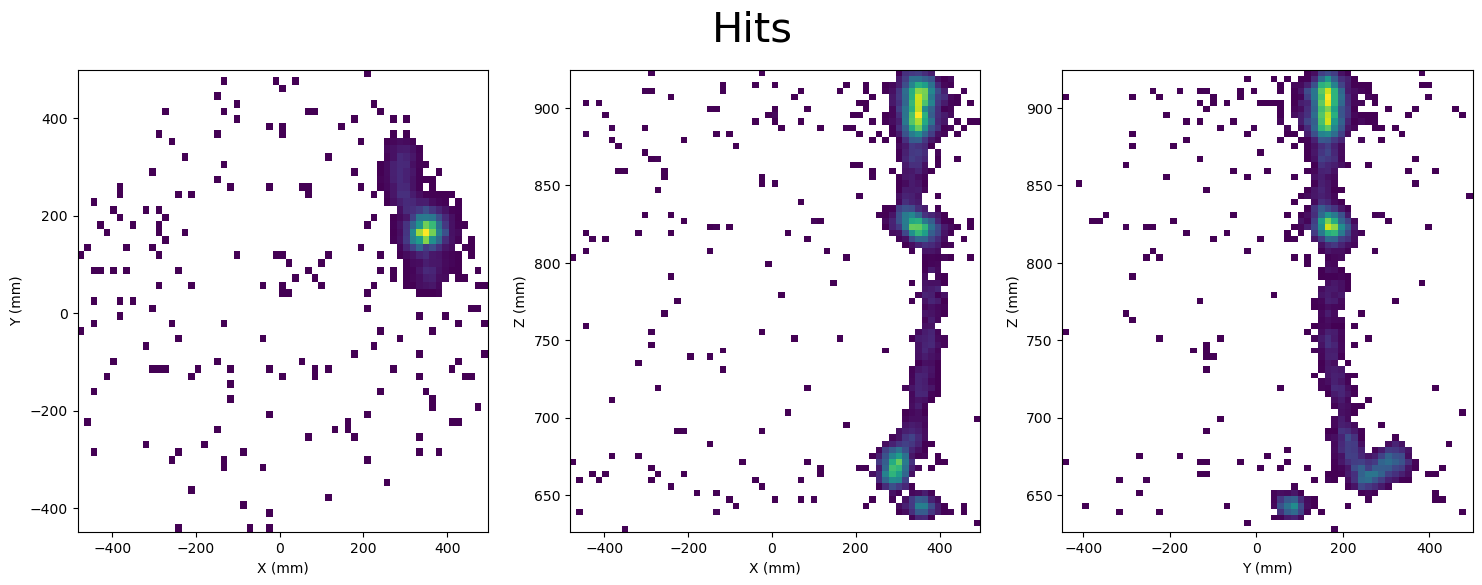

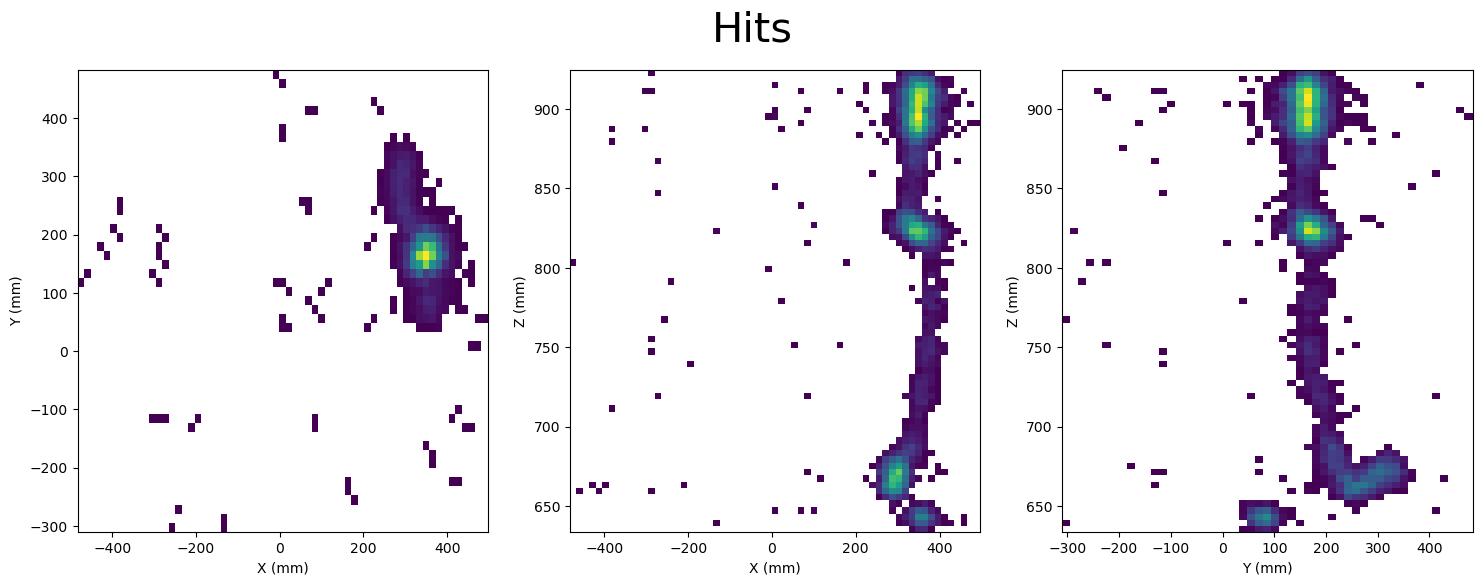

In [22]:
# look at each step
hits_cut = cut_sensors(event)
plot_hits(hits_cut)
hits_drop = drop_sensors(hits_cut)
plot_hits(hits_drop)

In [26]:
from typing  import List
from typing  import Tuple
from typing  import Callable
from typing  import Optional
from typing  import Union


def drop_isolated_sensors(distance  : List[float]=[10., 10.],
                          variables : List[str  ]=[        ]) -> Callable:
    """
    Drops rogue/isolated hits (SiPMs) from a groupedby dataframe.

    Parameters
    ----------
    df      : GroupBy ('event' and 'npeak') dataframe

    Initialization parameters:
        distance  : Distance to check for other sensors. Usually equal to sensor pitch.
        variables : List with variables to be redistributed.

    Returns
    -------
    pass_df : hits after removing isolated hits
    """
    dist = np.sqrt(distance[0] ** 2 + distance[1] ** 2)

    def drop_isolated_sensors(df : pd.DataFrame) -> pd.DataFrame:
        x       = df.X.values
        y       = df.Y.values
        xy      = np.column_stack((x,y))
        dr2     = cdist(xy, xy) # compute all square distances

        if not np.any(dr2>0):
            return df.iloc[:0] # Empty dataframe

        closest = np.apply_along_axis(lambda d: d[d > 0].min(), 1, dr2) # find closest that it's not itself
        mask_xy = closest <= dist # take those with at least one neighbour
        pass_df = df.loc[mask_xy, :].copy()

        with np.errstate(divide='ignore'):
            columns  = pass_df.loc[:, variables]
            columns *= np.divide(df.loc[:, variables].sum().values, columns.sum())
            pass_df.loc[:, variables] = columns

        return pass_df

    return drop_isolated_sensors

In [ ]:
from scipy                  import ndimage as ndi


def collect_component_sizes(im_mask : np.ndarray) -> (np.ndarray, np.ndarray):
    '''
    A function that returns the sizes of different clusters of 1s and 0s within the data
    for removal of satellites.

    This function uses the scipy ndimage library to identify different 'clusters' of 1s within the slice, and
    checks if these clusters are below the size considered for satellite deposits (`satellite_max_size`).
    The method is described in more detail here:
    https://gist.github.com/jwaiton/fd14f43e8da28a49c9c49d43eb00f53f

    Parameters
    ----------
    im_mask : 2D boolean array describing the regions of energy in deconvolution slice

    Returns
    -------
    labels          : 2D array equivalent to im_mask with each region labelled 0, 1, 2, etc
    component_sizes : Array of the length of each component size
    '''
    # label deposits within the array
    # hardcoded to include diagonals in the grouping stage (2)
    # count the bins of each labelled deposit
    footprint       = ndi.generate_binary_structure(im_mask.ndim, 2)
    labels, _       = ndi.label(im_mask, footprint)
    component_sizes = np.bincount(labels.ravel())
    return labels, component_sizes

In [ ]:
def drop_isolated_clusters(df            : pd.DataFrame
                          , cluster_size : int): -> pd.DataFrame
    '''
    Exclude spurious SiPM clusters with size smaller than
    defined.
    '''

In [37]:
test_array = np.array([[[0, 0, 1, 1],
                        [0, 0, 0, 1],
                        [0, 0, 0, 0],
                        [1, 0, 0, 0]],
                       [[0, 0, 0, 0],
                        [0, 0, 0, 0],
                        [0, 0, 1, 0],
                        [1, 0, 0, 0]],
                       [[0, 0, 0, 0],
                        [0, 0, 0, 0],
                        [0, 0, 1, 1],
                        [1, 0, 0, 0]]])

print(f'{test_array}\n')
print(f'{test_array[0]}\n')
print(f'{test_array[0][0]}\n')
print(f'{test_array[0][0][0]}\n')

labels, component_sizes = collect_component_sizes(test_array)
print(labels, component_sizes)

[[[0 0 1 1]
  [0 0 0 1]
  [0 0 0 0]
  [1 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 1 0]
  [1 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 1 1]
  [1 0 0 0]]]

[[0 0 1 1]
 [0 0 0 1]
 [0 0 0 0]
 [1 0 0 0]]

[0 0 1 1]

0

[[[0 0 1 1]
  [0 0 0 1]
  [0 0 0 0]
  [2 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 3 0]
  [2 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 3 3]
  [2 0 0 0]]] [39  3  3  3]


In [40]:
# now stacking the hit arrays such that you can create the same shape

x       = event.X.values
y       = event.Y.values
xy      = np.column_stack((x,y))

print(xy)
print(np.diff(xy, axis = 0))

[[-343.675 -185.975]
 [-343.675  184.225]
 [-265.925  168.675]
 ...
 [ 366.625  184.225]
 [ 351.075  198.775]
 [ 273.325 -185.975]]
[[   0.    370.2 ]
 [  77.75  -15.55]
 [  76.75  -16.05]
 ...
 [  15.55   15.55]
 [ -15.55   14.55]
 [ -77.75 -384.75]]


In [47]:
n_dim = 3
dimensions    = np.array  (['X', 'Y', 'Z'][:n_dim])
print(event.loc[:, dimensions].values.T)


det_db = DataSiPM('next100', 15107)
sample_width = [15.55, 15.55]
bin_size = 2.5
det_grid      = [np.arange(det_db[var].min() + bs/2, det_db[var].max() - bs/2 + np.finfo(np.float32).eps, bs)
                     for var, bs in zip(dimensions, bin_size)]
inter_method = InterpolationMethod.cubic


deconv_input = deconvolution_input(sample_width, det_grid, inter_method)

[[-343.675    -343.675    -265.925    ...  366.625     351.075
   273.325   ]
 [-185.975     184.225     168.675    ...  184.225     198.775
  -185.975   ]
 [ 626.325625  626.325625  626.325625 ...  924.776875  924.776875
   927.6835  ]]


OperationalError: unable to open database file